# Lab15: Clustering World Bank Data

In this lab you will be clustering World Bank observations of per capita GDP and the literacy rate of different countries.

We're going to see if we can cluster countries by literacy rates and GDP.  

We'll try a number of different clustering algorithms to test clustering to see how they perform.

In [1]:
import pandas as pd  # We'll do some more imports as we go along
import numpy as np
import seaborn as sns

# You will have to import more modules as we go along.

In [2]:
# These are the files we are going to load initially
fn_gdp_data = 'pcgdp_data.csv'
fn_lit_data = 'literacy_data.csv'

# Load in the data sets

Let's load in our data sets.  **Open them as a text file.  Note how they look**.  You'll have to make some settings changes to the regular `read_csv` to get the data to be loaded correctly.

For now make two data frames, one for the literacy data and one for the gdp data.


In [3]:
# Load in our GDP data
df_gdp = pd.read_csv(fn_gdp_data, skiprows=1, header=1)

In [4]:
# Load in our population data
df_lit = pd.read_csv(fn_lit_data, skiprows=1, header=1)


We're interested in 2020 data only.  Merge the 2020 data into a single data frame.  You may use whatever column names you'd like, but in the end we want a data frame with three columns:
+ Country Code (as the index)
+ 2020 per capita GDP
+ 2020 literacy rate

In [5]:
# Let's merge these two data frames together
df_merged = pd.DataFrame()
df_merged['Country Code'] = df_lit['Country Code']
df_merged['2020 PC GDP'] = df_gdp['2020']
df_merged['2020 Literacy'] = df_lit['2020']
df_merged.set_index('Country Code', inplace=True)
df_merged.head()

,2020 PC GDP,2020 Literacy
Country Code,,
ABW,NaN,NaN
AFE,1359.618224,NaN
AFG,516.747871,NaN
AFW,1710.073363,NaN
AGO,1776.166868,NaN


In [6]:
# Let's see how many missing values we have
df_merged.isna().sum(axis=0)


2020 PC GDP       24
2020 Literacy    214
dtype: int64

In [7]:
# It looks like we're going to have to sample from what we have.
# Let's be "lazy" and use only countries with data for 2020 for 
# both categories.

## Let's subset the data

We only want countries that have data for both 2020 per capita and 2020 literacy.  So let's exclude any rows where either data column is a nan.

There are many ways of doing this.  One way is to use Boolean vector operations to find just those rows that don't have NaN values in them for either the per capita GDP or literacy rate.

For example, if your data frame was called `df_merged` you can use this code (provided your column labels match):
    
    good_rows = ~ (df_merged['2020 PC GDP'].isna() | df_merged['2020 Literacy'].isna())
    df_merged = df_merged[good_rows]

The | operator means "logical OR" and the ~ operator means "negate" or flip trues to falses and vise versa.

In [8]:
# We want to get rid of all rows where either GDP or 
# litracy data is missing for 2020
# If we compute it as below, we get a vector
# of true and false values.  False values
# mean at least 1 column is NaN and we can
# exclude it
has_both = df_merged.isna().sum(axis=1) == 0

# Retrieve just the rows that have both
# values by indexing using the list of
# True and False values from has_both
df_merged=df_merged[has_both]
df_merged.info()


<class 'pandas.core.frame.DataFrame'>
Index: 52 entries, ARB to WLD
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   2020 PC GDP    52 non-null     float64
 1   2020 Literacy  52 non-null     float64
dtypes: float64(2)
memory usage: 1.2+ KB


## Let's plot the data

Let's do a scatter plot of our points to see what they look like.  We want the X axis to be the literacy in 2020 and the Y axis to be the GDP per capita in 2020.

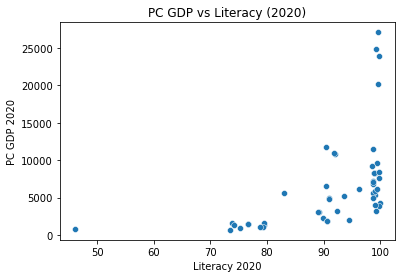

In [9]:
ax = sns.scatterplot(data=df_merged,
    y='2020 PC GDP', x='2020 Literacy'
)
ax.set_xlabel('Literacy 2020')
ax.set_ylabel('PC GDP 2020')
ax.set_title('PC GDP vs Literacy (2020)');

## Let's transform the data

Looking at the scatter plot you should see some clusters that might be identifiable.  But you should also take a look at the individual attributes themselves.  Look at the large range on GDP compared to literacy.  One is somewhere between 0 and 100 and the other 0 to 25k.  If we were to use raw values here, clearly the GDP would be the determining factor for clustering.

We need to transform our data to make sure it is scaled correctly for clustering.  There are a number of different ways to do this.  Today we are going to use a simple transformation called the [StandardScalar](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) that is part of SciKit Learn's preprocessing package.    Follow the example in the linked documentation to standardize the data we have.  We will be operating on this transformed data for our clustering analysis.

Make a second scatterplot of this transformed data.

In [10]:
# Use StandardScalar to transform our data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_merged);
trans = scaler.transform(df_merged);
type(trans)

numpy.ndarray

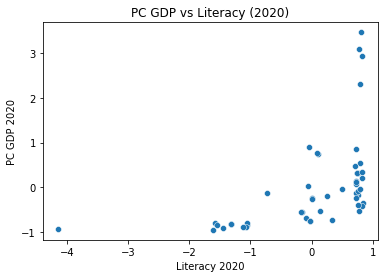

In [11]:
# Make a scatterplot of the transformed data
ax = sns.scatterplot(
    x=trans[:,1], y=trans[:,0]
)
ax.set_xlabel('Literacy 2020')
ax.set_ylabel('PC GDP 2020')
ax.set_title('PC GDP vs Literacy (2020)');

## Clustering our transformed data

Now that we've transformed (standardized) our data, we can go about trying to cluster.  We will use each of the three methods we've learned about to accomplish this.

There is no "best" way to cluster data.  It's an art and which method we use depends on the types of questions we are going to be asking.

Here we're just going to use all the methods to demonstrate how they differ in use.

### K-Means

I would like you to run a K-Means clustering analysis.

Assay over K of 2 to 8 inclusive.  You may use the default settings in scikit learn for KMeans.

I want you to produce a SSE plot that shows how SEE changes as the value of K increases.  This means you will have to collect the final SEE for each K we use. (It's the attribute inertia_ which is available after you call fit.)  

Then I would like you to pick what looks like (on the diagnostic plot) a reasonable K.

Make a scatterplot of the transformed data colored by the cluster label.  (Once you run fit the attribute labels_ becomes available that will give you the label number.  You can pass this vector as a hue argument to scatterplot.)

I'd also like you to draw the centroid centers as well, so collect that data for your "best K" by collecting its cluster_centers_ attribute that becomes available after you call `fit`.


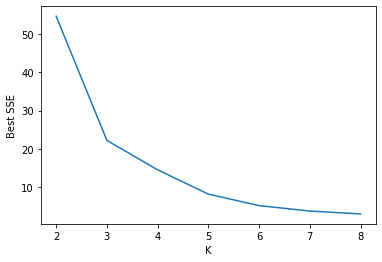

In [12]:
# Assay over K and plot the best SSE as a function of K to find which K to use
from sklearn.cluster import KMeans

best_sse = {}
km_labels = {}
centroids = {}
for k in range(2,9):
    cluster_km = KMeans(n_clusters=k)  # Prepare to cluster
    cluster_km.fit(trans)  # Do the clustering
    best_sse[k] = cluster_km.inertia_  # sse
    km_labels[k] = cluster_km.labels_
    centroids[k] = cluster_km.cluster_centers_

ax = sns.lineplot(x=best_sse.keys(), y=best_sse.values())
ax.set_xlabel('K')
ax.set_ylabel('Best SSE');

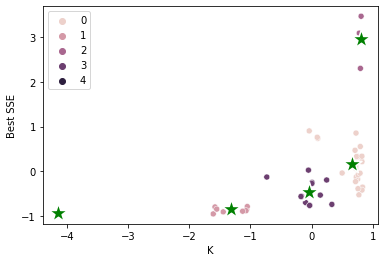

In [13]:
# Using the "best" K, plot the transformed data with the 
# hue being the label color (from the labels_ attribute of the model you fit)
# You can plot the centroids by using the values in cluster_centers_ 
ax = sns.scatterplot(x=trans[:,1], y=trans[:,0], hue=km_labels[5])
ax = sns.scatterplot(x=centroids[5][:,1], y=centroids[5][:,0], marker='*', color='g', s=400)
ax.set_xlabel('K')
ax.set_ylabel('Best SSE');

### Agglomerative clustering

Agglomerative clustering builds a tree (dendogram) by successively combining points and groups of points together until a single tree/cluster is produced.  We an then examine this dendogram to figure out how many clusters we might use.

First follow the instructions for Agglomerative Clustering you'll find on the [documentation page](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) for it.  We will set `n_clusters` after we take a look at the dendogram produced, so set it to `None` for now.  Also set `distance_threshold` to 0.

Make sure you are operating on the transformed data.

Import `plot_dendogram` from the `demo_tools` module included with today's exercise.  Simply pass in the AgglomerativeClustering model you fit to plot the denodgram.

Which `linkage` method should you use?  What should the `distance_threshold` be in your final clustering?  Use the denodgram and adjust the linkage setting to find one that looks like it works best for this data.  (For me `single` linkage worked best.  But you do have to look at the dendogram to find a good `distance_threshold` for which ever method you choose.)



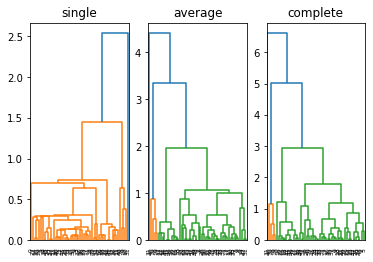

In [14]:
# Create a full dendogram for the clusters and plot it

# Distance or n_clusters to stop?
# Which linkage method to use?

from sklearn.cluster import AgglomerativeClustering
from demo_tools import plot_dendogram
import matplotlib.pyplot as plt

for ndx, method in enumerate(['single', 'average', 'complete']):
    plt.subplot(1,3,ndx+1)
    cluster_ag = AgglomerativeClustering(
        n_clusters=None,  # Want full tree
        distance_threshold=0, # Want a full tree
        linkage=method
    )
    cluster_ag.fit(trans)
    plot_dendogram(cluster_ag)
    plt.gca().set_title(method)

From your results above, you should see some natural places to cut our dendogram by examining either how many clusters we expect or setting a threshold distance, or how far away clusters should be.  Using which ever method you'd like, let's create our final agglomerative clustering.

Make a scatter plot of the transformed data and use the labels found from the clustering to color the points.

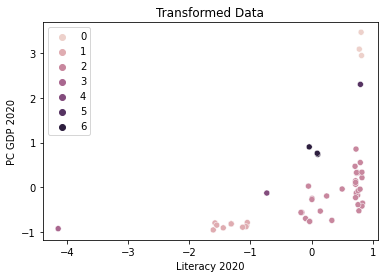

In [15]:
# Plot the "good" clustering you found
# as a scatterplot of the transformed data
# with the hue being based on the labels_ found
cluster_ag = AgglomerativeClustering(
    n_clusters=None,  # We're going rely on distance b/n clusters
    distance_threshold=0.5,  # Eyeballed from the dendogram above
    linkage='single',  # A choice.  Merge clusters based on nearest points. 
)
cluster_ag.fit(trans)  # After running we get our .labels_
ax = sns.scatterplot(y=trans[:,0], x=trans[:,1], hue=cluster_ag.labels_)
ax.set_xlabel('Literacy 2020')
ax.set_ylabel('PC GDP 2020')
ax.set_title('Transformed Data');

## DBSCAN

Our last clustering will be to use DBSCAN to perform the clustering.  Just as the previous two clustering algorithms required us to explore our results to find the a "good" set of parameter(s) for the clustering, we need to take a look at `eps` and `min_samples` to find good values for the clustering.  You can read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) for examples of how to use it.

But before we begin, let's take a look at all pairwise distances.  This will help us pick an `eps`.  Read the directions for `pairwise-distances` from the sklearn.metrics module.  Plot these distances using a seaborn `displot` with `kde=True` to see the curve.. You may need to call `flatten()` on the distance matrix you receive from `pairwise-distances` to get it to plot.

As for `min_samples`?  What is the smallest cluster size you'll allow?  This is up to you.  Points that don't belong to any cluster are considered outliers.

The purpose of the plot is to find a good `eps`, so we are looking for small values that are frequent.  These values are usually found near 0.  Examine the histogram and find a pairwise distance cut off.  It should be at a point in the graph where pairwise distances are separable (the valley between peaks in the plot). You may need to adjust the number of bins or filter your data to include only smaller values to get the resolution necessary for this task.



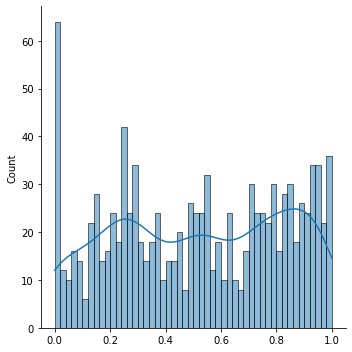

In [16]:
# Calculate all pairwise distances
# and make a displot to find a good value of eps
from sklearn.metrics import pairwise_distances
pdist = pairwise_distances(trans)
sns.displot(pdist[pdist < 1].flatten(), bins=50, kde=True)   # Closer to zero is where you should look for eps
# It looks like the first mode is around 0.4, so let's use that for eps

Text(0.5, 1.0, 'Transformed Data')

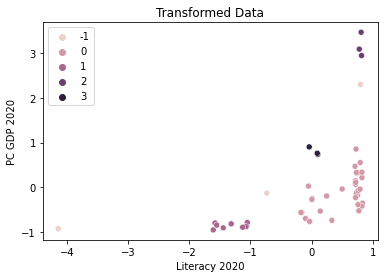

In [17]:
# Cluster using DBSCAN with the eps and min_samples you've decided upon
# Then make a scatterplot of the transformed data labeled by the labelings
# DBSCAN found
from sklearn.cluster import DBSCAN

cluster_db = DBSCAN(
    eps = 0.4,
    min_samples=3
)
cluster_db.fit(trans)
ax = sns.scatterplot(y=trans[:,0], x=trans[:,1], hue=cluster_db.labels_)
ax.set_xlabel('Literacy 2020')
ax.set_ylabel('PC GDP 2020')
ax.set_title('Transformed Data')